In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
n1      =   1.99
n0      =   1.4585
a       =   1e-6
b       =   1e-6
lambda0 =   1550e-9
k0      =   2 * np.pi / lambda0
c       =   299792458
u0      =   4 * np.pi * 1e-7
np.log10(k0*c)

np.float64(15.084668873115751)

In [48]:
# Class public variables:
# Shape of field profile
# Component_name_list

def str2complex(s):
    str = s.replace(" ","").replace("i","j")
    return complex(str)

def Load_field_profile(ModeIdx,component,PML_len = 2):
    # filename = "Mode1_Ex.txt"
    # filename = './ModeProfile/Mode'+str(ModeIdx)+'_'+component+'.txt'
    filename = './data/Mode Profiles/InnerRingXYZ_Lx_8um_bendr_1000um_20x10um_800x400cells_beta_ang_21_wavls/1500/Mode'+str(ModeIdx)+'_'+component+'.txt'

    Field = np.array([[]])
    with open(filename) as f:
        lines = f.readlines()
        Field = np.array([str2complex(s) for s in lines[0].split('\t')])
        for line in lines[1:]:
            line_arr = line.split('\t')
            Field = np.c_[Field,np.array([str2complex(s) for s in line_arr])]
    shape = np.shape(Field)
    Field = Field[int((PML_len)/2):-int((PML_len)/2), int((PML_len)/2):-int((PML_len)/2)]
    #print("# of lines:",len(lines))
    #print("# of columns:",len(lines[0].split('\t')))
    print("shape of loaded field " +component+" matrix:",np.shape(Field))
    return Field

In [49]:
'''
Note: All field profile matrixes use the first index for Y, the second index for X
E.g. Ex[100:][:] select the upper part of Ex, Ey[:][:-100] select the left part of Ey

'''
def Load_all_field_profile(ModeIdx,plot=True,PML_len = 23):

    Ex = Load_field_profile(ModeIdx,'Ex')
    Ey = Load_field_profile(ModeIdx,'Ey')
    Ez = Load_field_profile(ModeIdx,'Ez')
    Hx = Load_field_profile(ModeIdx,'Hx')
    Hy = Load_field_profile(ModeIdx,'Hy')
    Hz = Load_field_profile(ModeIdx,'Hz')

    component_list = [Ex,Ey,Ez,Hx,Hy,Hz]
    component_name_list = ['Ex','Ey','Ez','Hx','Hy','Hz']
    Field_dict = dict(zip(component_name_list,component_list))

    if plot ==True:
        Plot_all_field_profile(list(Field_dict.values()))

    return Field_dict


In [50]:
def Plot_field_profile(input_component,component_name):

    #component = np.transpose(input_component)
    component = input_component
    fig, ax = plt.subplots(1,3,figsize=(10, 5),dpi=200)
    plt.subplots_adjust(wspace =0.4, hspace =0.2)   #调整子图间距
    plt.rcParams.update({'font.size': 5})

    name_list = ['Abs','Re','Im']
    component_list = [np.abs(component),np.real(component),np.imag(component)]
    for idx in range(3):
        im = ax[idx].imshow(component_list[idx])
        ax[idx].set_title(name_list[idx]+'('+component_name+')')
        fig.colorbar(im,fraction=0.08, pad=0.05,orientation='vertical')
        ax[idx].set_xlabel("X")
        ax[idx].set_ylabel("Y")
        ax[idx].invert_yaxis()
        ax[idx].tick_params(axis='both',labelsize=5)


    plt.show()
    return


In [51]:
def Plot_all_field_profile(component_list):

    component_name_list = ['Ex','Ey','Ez','Hx','Hy','Hz']
    fig, ax = plt.subplots(4,3,figsize=(8, 10),dpi=200)
    plt.subplots_adjust(wspace =0.4, hspace =0.2)   #调整子图间距
    ax = ax.flatten()
    plt.rcParams.update({'font.size': 5})
    for i in range(4):
        for j in range(3):
            if i%2 == 0:
                im = ax[i*3+j].imshow(np.real(component_list[j if i<2 else j+3]), cmap='coolwarm')
                fig.colorbar(im,orientation='vertical')
                ax[i*3+j].set_title('Re('+component_name_list[j if i<2 else j+3]+')')

            else:
                im = ax[i*3+j].imshow(np.imag(component_list[j if i<2 else j+3]), cmap='coolwarm')
                fig.colorbar(im,orientation='vertical')
                ax[i*3+j].set_title('Im('+component_name_list[j if i<2 else j+3]+')')

            ax[i*3+j].set_xlabel("X")
            ax[i*3+j].set_ylabel("Y")
            ax[i*3+j].invert_yaxis()
            ax[i*3+j].tick_params(axis='both',labelsize=5)

    plt.show()
    return

In [52]:
def Field_normalization(component_list,P_total):
    component_list_normalized = np.copy(component_list)
    for idx in range(np.shape(component_list)[0]):
        component_list_normalized[idx] = component_list[idx] / np.sqrt(P_total)
    return component_list_normalized

shape of loaded field Ex matrix: (399, 799)
shape of loaded field Ey matrix: (399, 799)
shape of loaded field Ez matrix: (399, 799)
shape of loaded field Hx matrix: (399, 799)
shape of loaded field Hy matrix: (399, 799)
shape of loaded field Hz matrix: (399, 799)


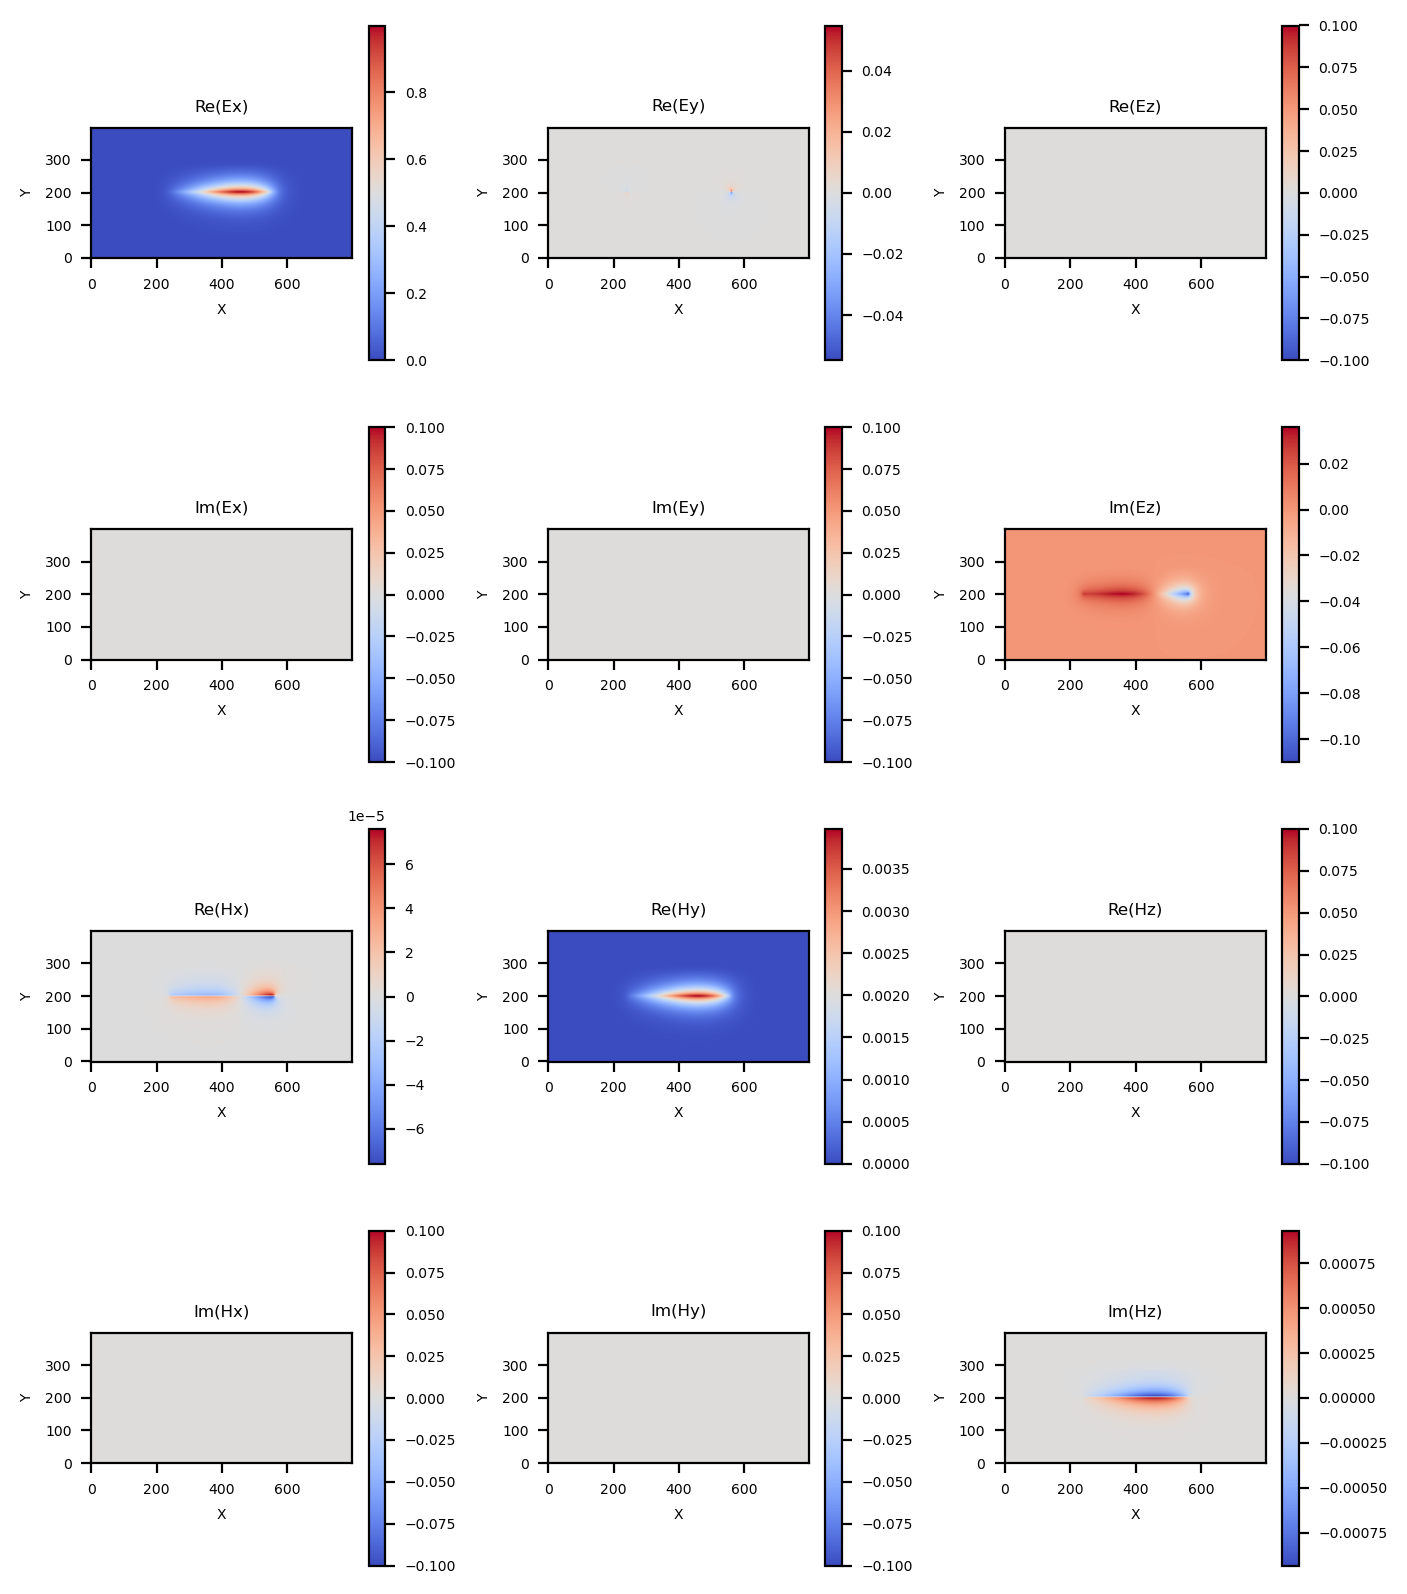

In [53]:
Field_dict = Load_all_field_profile(1)


P total = 33.003


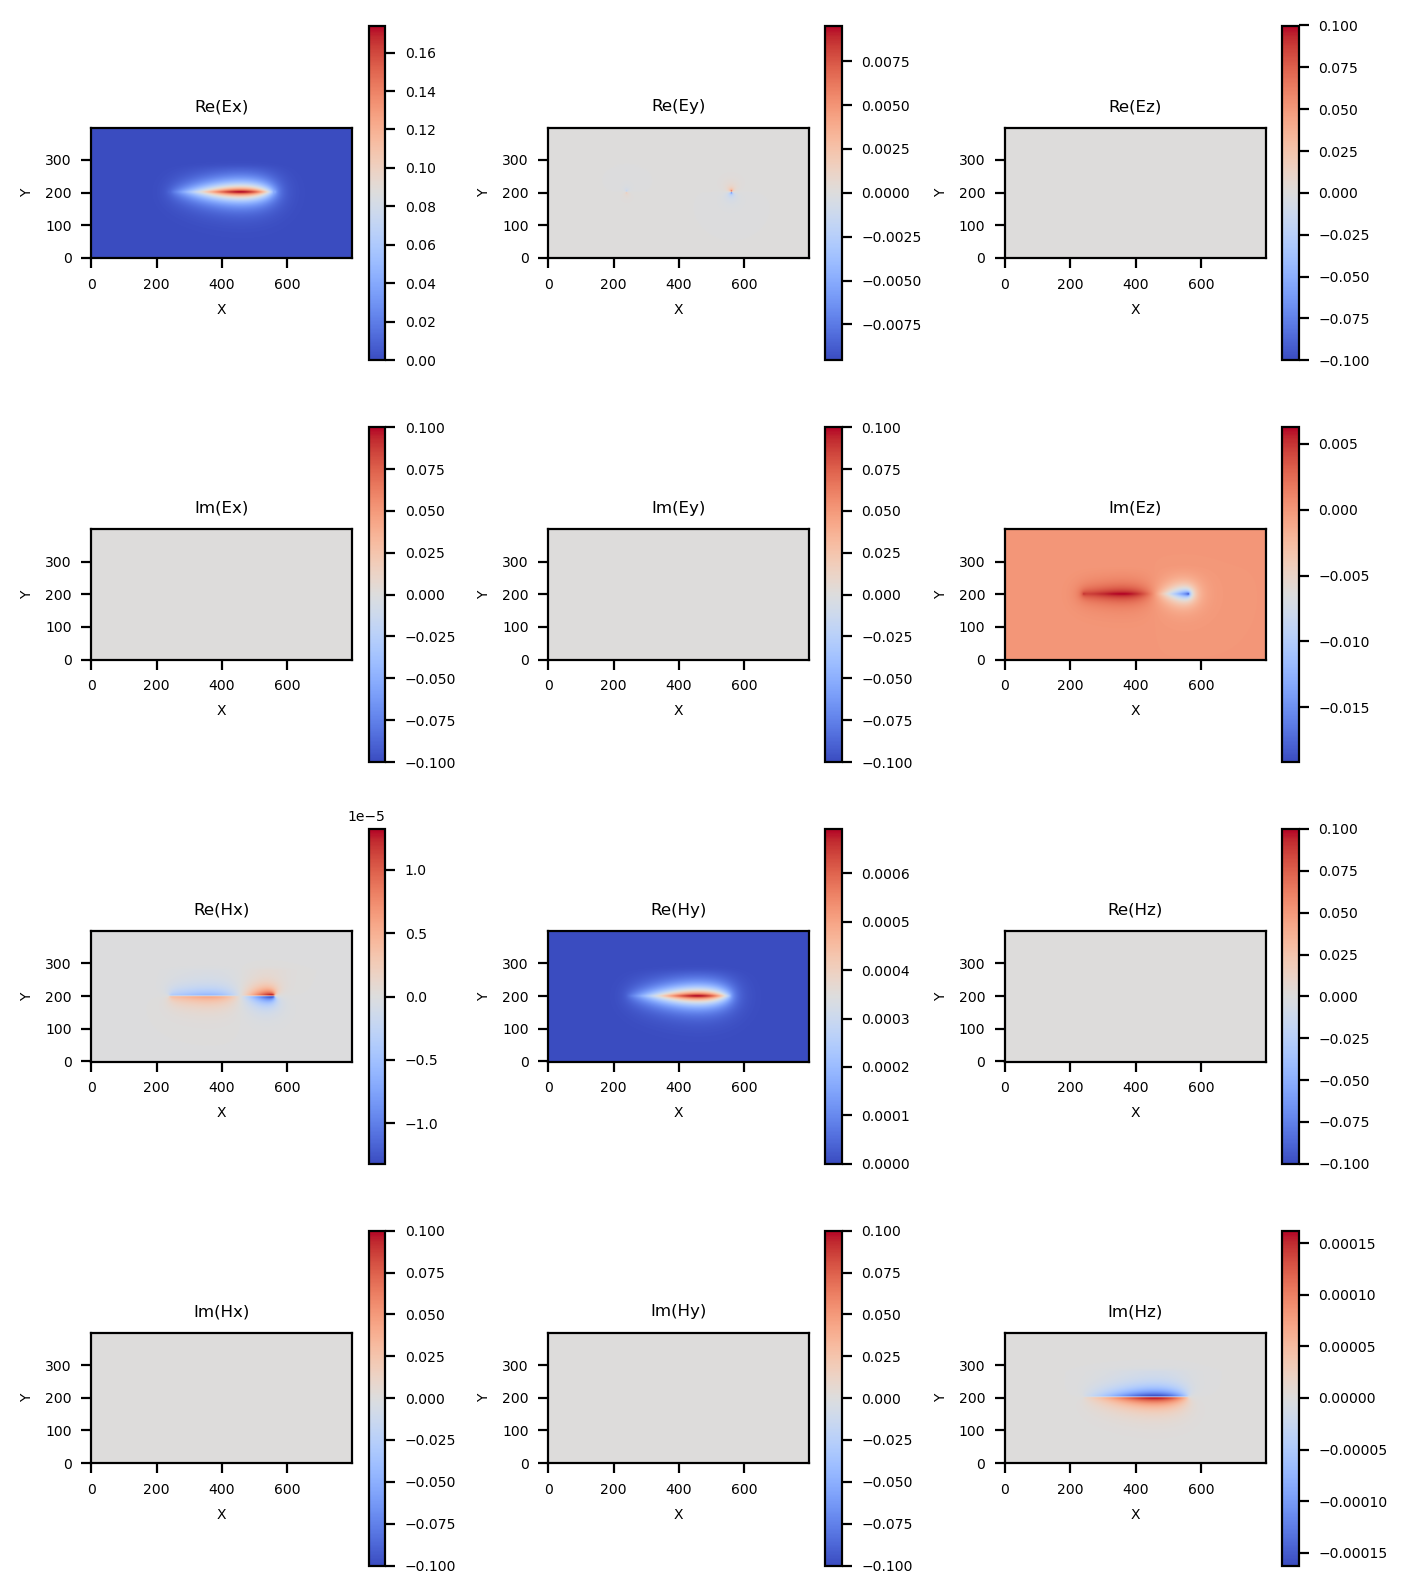

In [54]:
P_total = 2*np.real(np.sum(np.conj(Field_dict['Ex']) * Field_dict['Hy'] -
                           np.conj(Field_dict['Ey']) * Field_dict['Hx']))
print("P total = %.3f"%P_total)
field_component_normalized_list = Field_normalization(list(Field_dict.values()),P_total)
component_name_list = ['Ex','Ey','Ez','Hx','Hy','Hz']
Field_dict = dict(zip(component_name_list,field_component_normalized_list))
Plot_all_field_profile(list(Field_dict.values()))

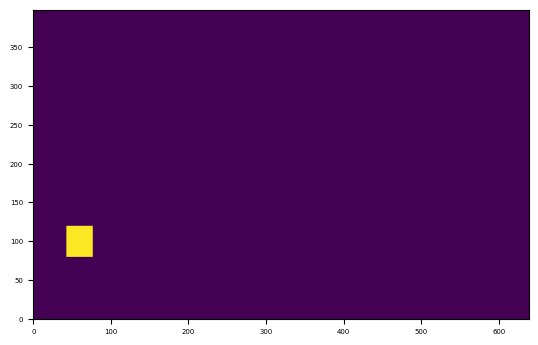

In [55]:
Field_profile_shape = np.shape(Field_dict['Ex'])
length_y = int(Field_profile_shape[0])
length_x = int(Field_profile_shape[1]*0.8)
Field_dict_uncoupled = dict.fromkeys(component_name_list)

for component in component_name_list:
    Field_profile_1 = np.zeros((length_y,length_x))
    Field_profile_1 = Field_dict[component][:,-length_x:]   #Left part of E_1y
    Field_profile_2 = np.zeros((length_y,length_x))
    Field_profile_2 = Field_dict[component][:,:length_x]   #Right part of E_2y
    Field_dict_uncoupled[component] = [Field_profile_1,Field_profile_2]

Field_profile_shape_compressed = np.shape(Field_dict_uncoupled['Ex'][0])

N  = np.ones(Field_profile_shape_compressed) * n0
N[80:120, 100-17-40:100+17-40] = n1
N[80:120, 100-17:100+17] = n1

N1  = np.ones(Field_profile_shape_compressed) * n0
N1[80:120, 100-17-40:100+17-40] = n1

N2  = np.ones(Field_profile_shape_compressed) * n0
N2[80:120, 100-17:100+17] = n1


plt.imshow(N*N-N2*N2)
plt.gca().invert_yaxis()

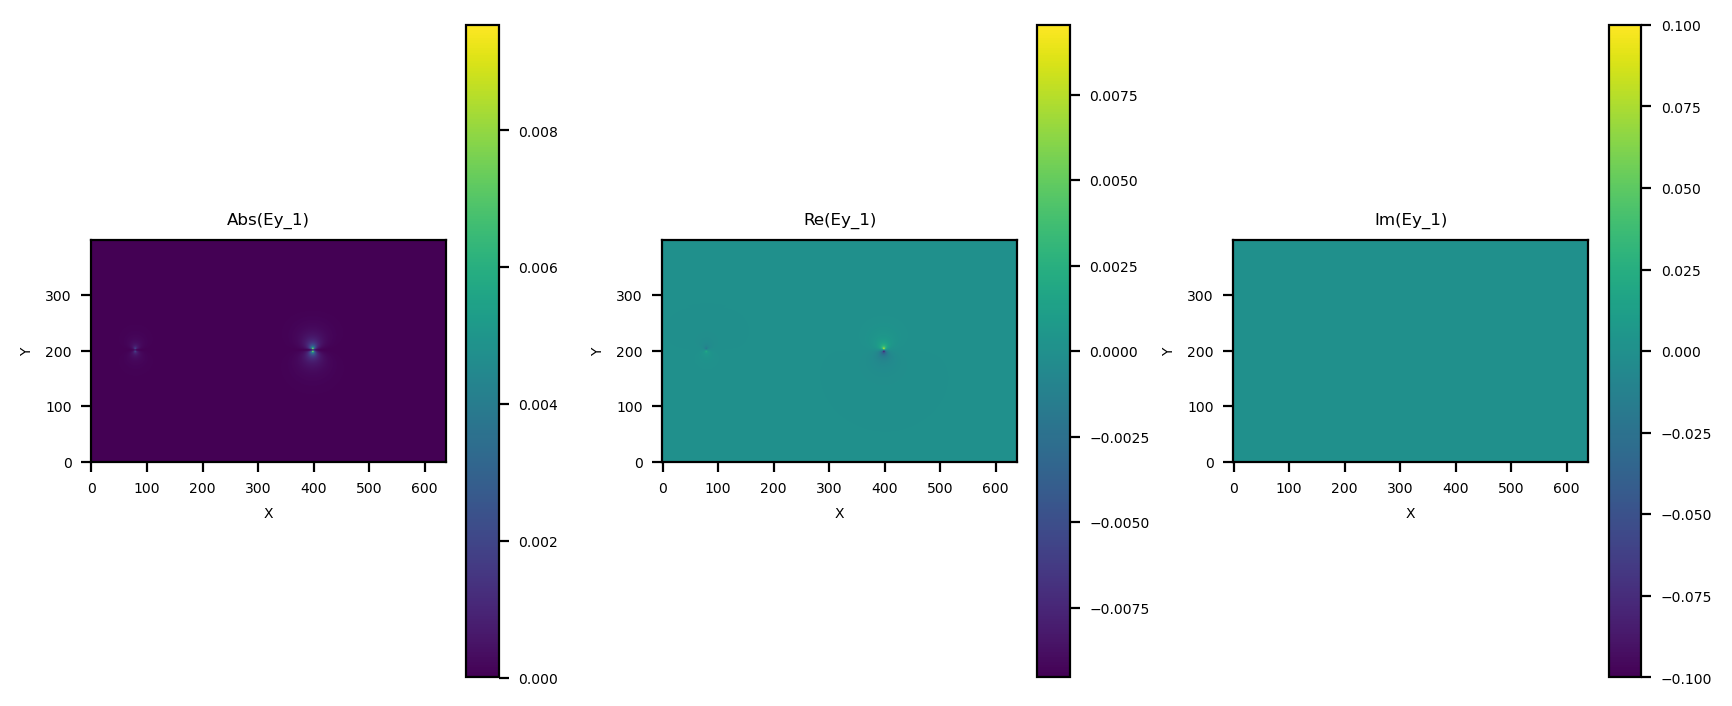

In [56]:
Plot_field_profile(Field_dict_uncoupled['Ey'][0],'Ey_1')

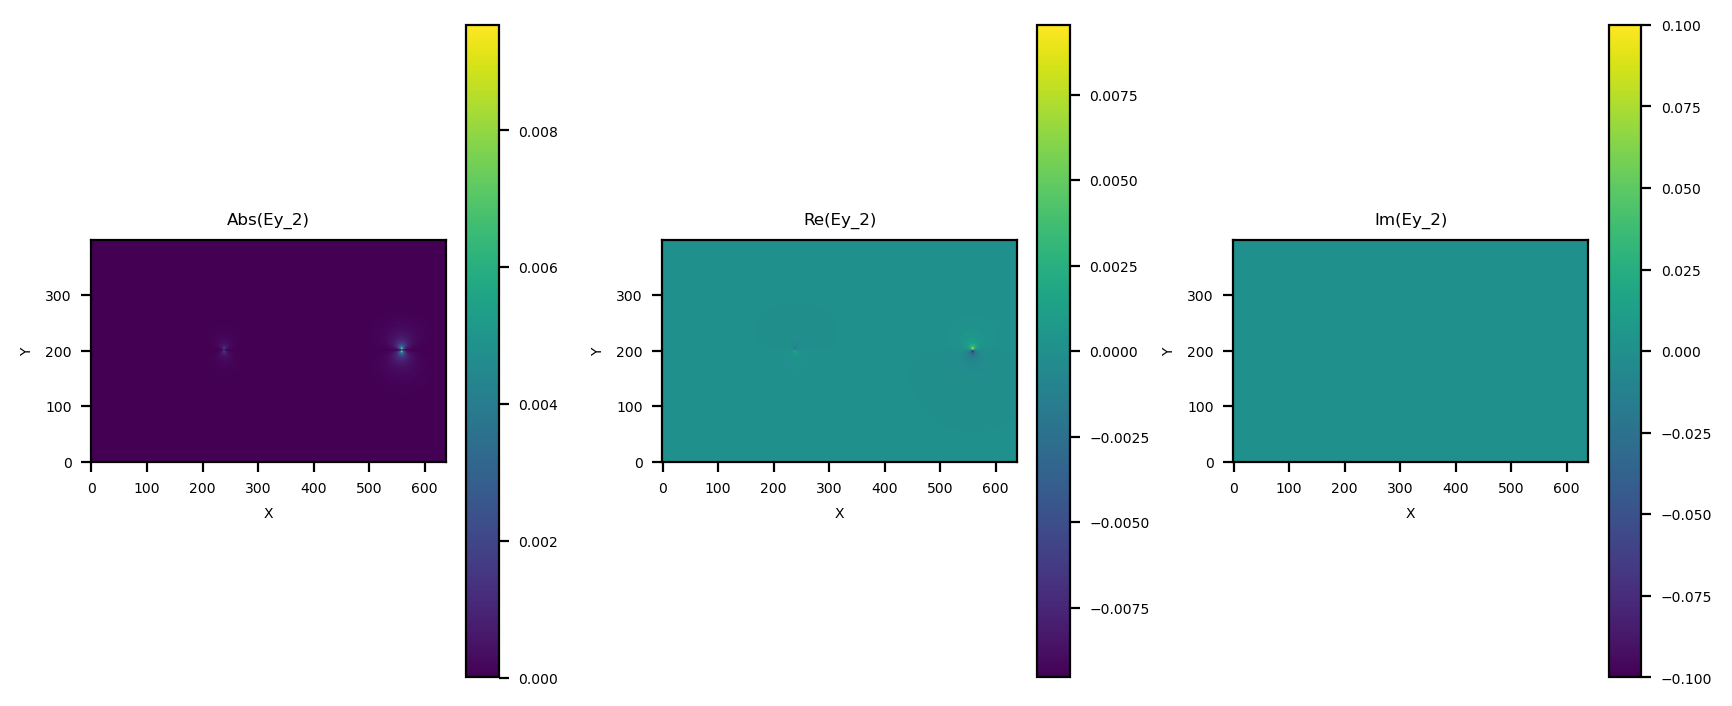

In [57]:
Plot_field_profile(Field_dict_uncoupled['Ey'][1],'Ey_2')

In [58]:
#Coupling Coefficients:
#Mode-coupling coefficient: Kpq
#Kpq = 2*pi*f * epsilon0 * int_0^Inf dx dy (N^2-N_q^2) * np.conj(Ep) * Eq

#Butt-coupling coefficient: Cpq

# P(p,q) = int_0^Inf dx dy [ Ep * np.conj(Hq) + np.conj(Ep) * Hq ]
def P_factor(p_, q_,):
    p = p_ - 1
    q = q_ - 1
    P = 2*np.real(np.sum(np.conj(Field_dict_uncoupled['Ex'][p]) *\
                        Field_dict_uncoupled['Hy'][q] -
                        np.conj(Field_dict_uncoupled['Ey'][p]) *\
                        Field_dict_uncoupled['Hx'][q]))
    return P

# C(p,q) = int_0^Inf dx dy [ Ep * np.conj(Hq) ]
def C_factor(p_, q_, N, Np):
    p = p_ - 1
    q = q_ - 1
    C = np.sum((N*N-Np*Np)*(np.conj(Field_dict_uncoupled['Ex'][p] * \
                                    Field_dict_uncoupled['Ex'][q] + \
                            np.conj(Field_dict_uncoupled['Ey'][p]) * \
                                    Field_dict_uncoupled['Ey'][q] + \
                            np.conj(Field_dict_uncoupled['Ez'][p]) * \
                                    Field_dict_uncoupled['Ez'][q]) ))
    return np.real(C)


In [59]:
np.shape(Field_dict_uncoupled['Ey'][1])

(399, 639)

In [60]:
P_factor(1,1)

np.float64(0.9999997814266235)

In [61]:
P_factor(1,2)

np.float64(0.37316469466180757)

In [62]:
C_factor(1,1,N,N1)

np.float64(0.0010918793771091055)

In [63]:
#M Dz [A B] = C [A B]
M = np.array([[P_factor(1,1), P_factor(1,2)],
              [P_factor(2,1),P_factor(2,2)]])
assert not np.linalg.det(M) == 0
M_inv = np.linalg.inv(M)
M_inv

array([[ 1.16101481, -0.43325465],
       [-0.43148391,  1.16102772]])

In [64]:
C = np.array([[C_factor(1,1,N,N1),C_factor(2,1,N,N2)],
              [C_factor(1,2,N,N1),C_factor(2,2,N,N2)]])
C

array([[1.09187938e-03, 5.07744895e-07],
       [6.53131341e-06, 1.56206142e-09]])

In [65]:
#Dz [A B] = M_inv C [A B] = N [A B]
N = M_inv * C
N

array([[ 1.26768813e-03, -2.19982837e-07],
       [-2.81815662e-06,  1.81359661e-09]])

In [66]:
# N = N_sym + N_antisym
N_sym =  np.diag(np.ones(2))*((N[0][0] + N[1][1])) /2
N_sym

array([[0.00063384, 0.        ],
       [0.        , 0.00063384]])

In [67]:
N_antisym = N - N_sym

In [68]:
# Eigenvalues = np.linalg.eig(M_inv * C)[0]
Eigenvalues = np.linalg.eig(N_antisym)[0]
Eigenvalues

array([ 0.00063384, -0.00063384])

In [69]:
Eigenvectors = np.linalg.eig(M_inv * C)[1]
Eigenvectors

array([[ 9.99997529e-01,  1.73530901e-04],
       [-2.22306459e-03,  9.99999985e-01]])

In [70]:
M_inv * C

array([[ 1.26768813e-03, -2.19982837e-07],
       [-2.81815662e-06,  1.81359661e-09]])

In [71]:
beta = k0 / (c*u0) * Eigenvalues
beta

array([ 6.82024139, -6.82024139])

In [72]:
NumFrequencyPoints = 20
for lam in np.linspace(1540,1560,NumFrequencyPoints):
    k = 2*np.pi/lam


In [ ]:
A = np.array([200,201])
B = np.array([201,203])
# np.min(A,B)

TypeError: only integer scalar arrays can be converted to a scalar index

In [65]:
import numpy as np
A = np.array([1,2,3])
A = A.reshape((1,3))
B =  np.array([[11,12,13],[21,22,23]])
B = B.reshape((2,3))
# np.concatenate((A,B),axis=0)
np.multiply(A,B)



array([[11, 24, 39],
       [21, 44, 69]])

In [45]:
np.min((A,B),axis=0)

array([[0, 2]])

In [59]:
A = np.array([[],[]])
for idx in range(3):
    A = np.insert(A,idx,[idx,idx+1],axis=1)
A


array([[0., 1., 2.],
       [1., 2., 3.]])

In [54]:

A

array([], shape=(1, 0), dtype=float64)